# Albumin

In [1]:
import logging
import pathlib
import shutil
import sys
import os
import itertools
from tqdm import tqdm
logging.basicConfig()

import scipy
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_validate
from matplotlib import pyplot as plt
from tdc import Evaluator
import numpy as np

from rdkit import Chem
from rdkit.Chem import MACCSkeys

sys.path.append('..')
from sbap.sdf import ChemblSdfReader
from sbap.featurizers.prolif_smina import SminaDockingPersistenceHandler, SminaConfig, DockedProlifFingerprintFeaturizer, SminaDockingScoreFeaturizer

In [2]:
sdf_file = pathlib.Path("../molecules/human_serum_albumin_CHEMBL_data.sdf")
protein_pdb_file = pathlib.Path("../molecules/4la0_human_serum_albumin_cleaned_without_ligand.pdb")
docked_ligands_target_directory = pathlib.Path("../molecules/albumin")

fingerprint_featurizer = DockedProlifFingerprintFeaturizer.create(
    logging_level=logging.INFO,
)
docking_score_featurizer = SminaDockingScoreFeaturizer(logging.INFO)

In [3]:
fingerprint_featurizer.fit(protein_pdb_file, docked_ligands_target_directory)

  0%|          | 0/494 [00:00<?, ?it/s]

In [4]:
X, y = fingerprint_featurizer.transform(protein_pdb_file, docked_ligands_target_directory)
X.shape

  0%|          | 0/494 [00:00<?, ?it/s]

(494, 139)

### Label Transformation
our labels are in the range [0, 100] with a significant peak around 100, hence we transform y accordingly:
y := 100.1 - y

box-cox transformation lambda: 0.12167369193985009


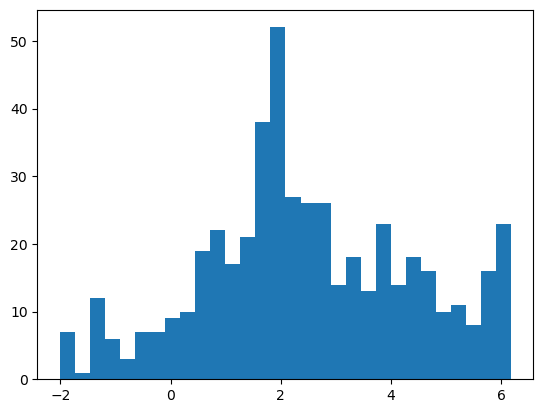

In [5]:
dataset_siz = X.shape[0]
y = np.array(y, dtype='f')
# SPECIAL TRANSFORMATION
y = 100.1 - y
old_y = y  # in case you have to restore y
y, lambda_ = scipy.stats.boxcox(y)
print(f'box-cox transformation lambda: {lambda_}')
plt.hist(y, bins=30)
plt.show()

### Remove anomalies

For some reason some docking results are very big, even positive

(494, 139)
new shape: (494, 139)


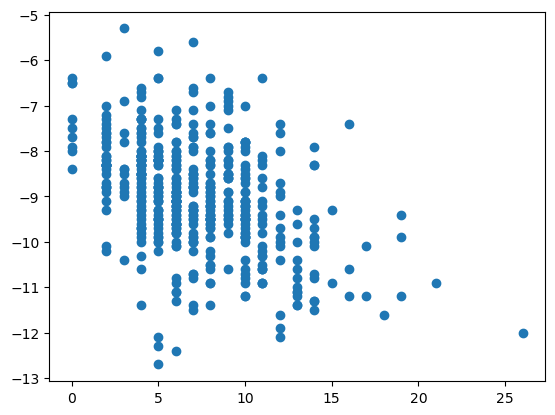

In [6]:
print(X.shape)
good_indices = np.argwhere(X[:, 0] < -2.0).flatten()
X = X[good_indices, :]
y = y[good_indices]
print(f'new shape: {X.shape}')
A = np.sum(X[:, 1:], axis=1)
plt.scatter(A, X[:, 0])
plt.show()

# Regression

In [19]:
rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')

In [20]:
"""
uses 5-cross validation to estimate model performance
"""
def evaluate_regression_model(model, X, y):
    scoring = ['neg_mean_absolute_error', 'r2']
    results = cross_validate(estimator=model, X=X, y=y, cv=5, scoring=scoring)
    return np.mean(results['test_r2']) + np.mean(results['test_neg_mean_absolute_error'])

def test_regression_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)

    fig, ax = plt.subplots()
    ax.axline((0, 0), slope=1)
    
    predictions = model.predict(x_train)  
    rmse_score = rmse(y_train, predictions)
    mae_score = mae(y_train, predictions)
    r2_score = r_squared(y_train, predictions)
    print(f'on train set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_train, predictions)

    predictions = model.predict(x_test) 
    rmse_score = rmse(y_test, predictions)
    mae_score = mae(y_test, predictions)
    r2_score = r_squared(y_test, predictions)
    print(f'on test set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_test, predictions)
    plt.show()

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge

# you can try multiple configurations
regression_model_list = [
    (RandomForestRegressor, {
        'n_estimators': [300, 500, 800], 
        'min_samples_leaf': [2, 4, 8], 
        'max_features': ['log2', 'sqrt', None]
    }),
    (MLPRegressor, {
        'hidden_layer_sizes': [(100,), (300,), (256, 128), (128, 64, 32), (100, 100)], 
        'activation': ['logistic', 'tanh', 'relu'],
        'early_stopping': [True, False]
    }),
    (Ridge, {
        'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
    }),
]

In [22]:
def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values()))

scores = []
best_score = -10.0
best_params = ()
best_model_type = None

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

for model_type in regression_model_list:
    for params in tqdm(my_product(model_type[1])):
        model = model_type[0](**params)
        score = evaluate_regression_model(model, x_train, y_train)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_model_type = model_type[0]
            best_params = params
    print(f'done with {model_type[0]}')
print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')

27it [01:14,  2.76s/it]


done with <class 'sklearn.ensemble._forest.RandomForestRegressor'>


30it [01:48,  3.62s/it]


done with <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>


10it [00:00, 58.94it/s]

done with <class 'sklearn.linear_model._ridge.Ridge'>
best_model_type = <class 'sklearn.ensemble._forest.RandomForestRegressor'>, best_params = {'n_estimators': 500, 'min_samples_leaf': 4, 'max_features': None}, best_score = -1.2509594373825164


best_model_type = <class 'sklearn.ensemble._forest.RandomForestRegressor'>, best_params = {'n_estimators': 500, 'min_samples_leaf': 4, 'max_features': None}, best_score = -1.2509594373825164
on train set: RMSE, MAE, R2 = 1.341913455353599, 1.0129248451512343, 0.5171123005691729
on test set: RMSE, MAE, R2 = 1.6052546802410925, 1.2367962228723677, 0.30272828122204287


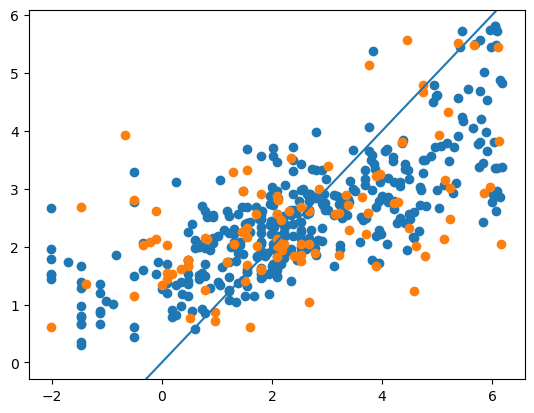

In [23]:
print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')
model = best_model_type(**best_params)
test_regression_model(model, x_train, x_test, y_train, y_test)

# Binary Classification

### Label transformation

In [9]:
THRESHOLD = 2.0
high_pic50 = np.argwhere(y > THRESHOLD).flatten()
yb = np.zeros(y.shape)
yb[high_pic50] = 1.0
yb = np.array(yb, dtype='i')
print(f'fraction of 1\'s: {sum(yb) / len(yb)}')

fraction of 1's: 0.611336032388664


In [14]:
acc = Evaluator(name = 'Accuracy')
prec = Evaluator(name = 'Precision')
recall = Evaluator(name = 'Recall')

def evaluate_classification_model(model, X, yb):
    scoring = ['accuracy', 'precision', 'recall']
    results = cross_validate(estimator=model, X=X, y=yb, cv=5, scoring=scoring)
    return np.mean(results['test_accuracy']) + np.mean(results['test_precision']) + np.mean(results['test_recall'])


def test_classification_model(model, xb_train, xb_test, yb_train, yb_test):
    model.fit(xb_train, yb_train)

    predictions = model.predict(xb_train)  
    print(predictions[:30])
    print(yb_train[:30])
    acc_score = acc(yb_train, predictions)
    prec_score = prec(yb_train, predictions)
    recall_score = recall(yb_train, predictions)
    print(f'on train set: Accuracy, Precision, Recall = {acc_score}, {prec_score}, {recall_score}')

    predictions = model.predict(xb_test) 
    print(predictions[:30])
    print(yb_test[:30])
    acc_score = acc(yb_test, predictions)
    prec_score = prec(yb_test, predictions)
    recall_score = recall(yb_test, predictions)
    print(f'on test set: Accuracy, Precision, Recall = {acc_score}, {prec_score}, {recall_score}')

In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

classification_model_list = [
    (RandomForestClassifier, {}),
    (AdaBoostClassifier,     {'n_estimators': [15, 31, 61]}),
    (SVC,                    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.3, 1.0, 3.0]}),
    (MLPClassifier,          {'hidden_layer_sizes': [80, 50, 30, 10], 'alpha': [0.3, 1.0, 3.0]}),
    (LogisticRegression,     {'penalty': ['l1', 'l2'], 'C': [0.3, 1.0, 3.0], 'solver': ['liblinear']}),
]

In [17]:
def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values()))

scores = []
best_score = -10.0
best_params = ()
best_model_type = None

xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)

for model_type in classification_model_list:
    for params in my_product(model_type[1]):
        model = model_type[0](**params)
        score = evaluate_classification_model(model, xb_train, yb_train)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_model_type = model_type[0]
            best_params = params
    print(f'done with {model_type[0]}')
print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')

done with <class 'sklearn.ensemble._forest.RandomForestClassifier'>
done with <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
done with <class 'sklearn.svm._classes.SVC'>
done with <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
done with <class 'sklearn.linear_model._logistic.LogisticRegression'>
best_model_type = <class 'sklearn.svm._classes.SVC'>, best_params = {'kernel': 'poly', 'C': 1.0}, best_score = 2.2458802553847725


In [18]:
model = best_model_type(**best_params)
test_classification_model(model, xb_train, xb_test, yb_train, yb_test)

[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1]
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1]
on train set: Accuracy, Precision, Recall = 0.6835443037974683, 0.6676384839650146, 0.9541666666666667
[0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0]
on test set: Accuracy, Precision, Recall = 0.696969696969697, 0.686046511627907, 0.9516129032258065
